# 250615 테스트

* 프롬프트 테스트
* kill_table 로직 추가

In [2]:
import os
import re
import json
import jsonlines
from typing import Annotated, Optional, Literal, List, Dict, Any
from datetime import datetime, timedelta
import operator
from uuid import uuid4

from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_naver.embeddings import ClovaXEmbeddings
from langchain_milvus.vectorstores import Milvus
from langchain_naver.chat_models import ChatClovaX
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
    AttributeInfo,
    StructuredQueryOutputParser,
    get_query_constructor_prompt
)
from langchain.retrievers.self_query.milvus import MilvusTranslator

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, field_validator
import warnings

warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

# 기존 모델 클래스들 유지
class TimeFilter(BaseModel):
    start_date: Optional[datetime] = None
    end_date: Optional[datetime] = None

class SearchQuery(BaseModel):
    query: str
    time_filter: TimeFilter

class Label(BaseModel):
    chunk_id: int = Field(description="The unique identifier of the text chunk")
    chain_of_thought: str = Field(description="The reasoning process used to evaluate the relevance")
    relevancy: int = Field(description="Relevancy score from 0 to 10, where 10 is most relevant", ge=0, le=10)

class RerankedResults(BaseModel):
    labels: list[Label] = Field(description="List of labeled and ranked chunks")

    @field_validator("labels")
    @classmethod
    def model_validate(cls, v: list[Label]) -> list[Label]:
        return sorted(v, key=lambda x: x.relevancy, reverse=True)

# LangGraph State 정의
class AgentState(TypedDict):
    question: str
    routing_result: str
    routing_result_2: str
    expr: Optional[str]
    text_context: List[Document]
    table_context: List[Document]
    raptor_context: List[Document]
    image_context: List[Document]
    text_answer: str
    table_answer: str
    final_answer: str
    messages: Annotated[List, add_messages]

# 초기화
embeddings = ClovaXEmbeddings(model='bge-m3')
llm = ChatClovaX(model='HCX-005', temperature=0)

URI = 'http://127.0.0.1:19530'

# 데이터베이스 초기화
text_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='text_db'
)

table_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='table_db'
)

raptor_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='raptor_db'
)

image_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='image_db'
)

# BM25 리트리버 초기화
filepath_text = './chunked_jsonl/text_semantic_per_80.jsonl'
filepath_table = './chunked_jsonl/table_v7.jsonl'

def load_documents(filepath):
    docs = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('\n('):
                continue
            data = json.loads(line)
            doc = Document(
                page_content=data['page_content'],
                metadata=data['metadata']
            )
            docs.append(doc)
    return docs

splitted_doc_text = load_documents(filepath_text)
splitted_doc_table = load_documents(filepath_table)

bm25_retriever_text = KiwiBM25Retriever.from_documents(splitted_doc_text)
bm25_retriever_text.k = 50

bm25_retriever_table = KiwiBM25Retriever.from_documents(splitted_doc_table)
bm25_retriever_table.k = 20

# 유틸리티 함수들
def adjust_time_filter_to_week(time_filter):
    start_date = time_filter.start_date
    end_date = time_filter.end_date
    
    if start_date is None or end_date is None:
        if start_date is not None and end_date is None:
            start_of_week = start_date - timedelta(days=start_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        elif end_date is not None and start_date is None:
            start_of_week = end_date - timedelta(days=end_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        else:
            return None

    if start_date.year == end_date.year and start_date.month == end_date.month and start_date.day == end_date.day:
        start_of_week = start_date - timedelta(days=start_date.weekday())
        end_of_week = start_of_week + timedelta(days=6)
        return {
            "start_date": start_of_week.replace(hour=0, minute=0, second=0),
            "end_date": end_of_week.replace(hour=23, minute=59, second=59)
        }

    return {"start_date": start_date, "end_date": end_date}

def parse_search_query_response(response: str, question: str) -> SearchQuery:
    try:
        data = json.loads(response.content)
        if data.get("time_filter") is None:
            data["time_filter"] = {}
        if "query" not in data:
            data["query"] = question
        return SearchQuery(**data)
    except Exception:
        return SearchQuery(query=question, time_filter=TimeFilter())

def format_docs(docs):
    return "\n\n".join(
        f"Issue Date: {doc.metadata.get('issue_date', 'Unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )

# LangGraph 노드 함수들 (HyperCLOVA X 최적화 프롬프트 적용)
def extract_date_node(state: AgentState) -> AgentState:
    """날짜 추출 노드"""
    question = state["question"]
    today = datetime(2025, 1, 25)
    days_since_last_friday = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_since_last_friday)
    issue_date = last_friday.strftime("%Y-%m-%d")

    system_prompt = f"""
당신은 금융 질의에서 날짜 범위를 추출하는 AI 어시스턴트입니다.
현재 리포트 날짜는 {issue_date}입니다.

**작업 지시:**
1. 사용자 질문에서 관련 날짜 또는 날짜 범위를 추출하세요
2. YYYY-MM-DD 형식으로 변환하세요
3. 날짜가 명시되지 않은 경우 null 값으로 응답하세요

**출력 형식:**
반드시 아래 JSON 형태로만 응답하세요:
{{
    "query": "원본 질문",
    "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} 또는 {{"start_date": null, "end_date": null}}
}}

**예시:**
- 질문: "이번 주 채권 시장 동향은?"
- 응답: {{"query": "이번 주 채권 시장 동향은?", "time_filter": {{"start_date": "2025-01-20", "end_date": "2025-01-26"}}}}
"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
    ]
    
    response = llm.invoke(messages)
    search_query = parse_search_query_response(response, question)
    parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

    if parsed_dates:
        start = parsed_dates['start_date']
        end = parsed_dates['end_date']
        expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
    else:
        expr = None

    return {"expr": expr}

def routing_node(state: AgentState) -> AgentState:
    """라우팅 노드 - 요약/예측/일반 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''다음 사용자 질문을 정확히 분류하세요.

**분류 기준:**
- 요약: 특정 기간의 내용을 종합하거나 정리하는 질문
- 예측: 미래 전망이나 예상에 관한 질문  
- 일반: 특정 정보나 사실을 묻는 질문

**질문:**
{question}

**지시사항:**
- 반드시 "요약", "예측", "일반" 중 하나의 단어로만 응답하세요
- 다른 설명은 추가하지 마세요

분류:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result": response.content.strip()}

def routing_2_node(state: AgentState) -> AgentState:
    """라우팅 노드 2 - 날짜/호수 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''다음 사용자 질문의 검색 방식을 분류하세요.

**분류 기준:**
- 날짜: 특정 날짜나 기간을 기준으로 검색하는 질문
- 호수: 특정 호수나 발행 번호를 기준으로 검색하는 질문

**질문:**
{question}

**지시사항:**
- 반드시 "날짜" 또는 "호수" 중 하나의 단어로만 응답하세요
- 다른 설명은 추가하지 마세요

분류:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result_2": response.content.strip()}

def text_retrieval_node(state: AgentState) -> AgentState:
    """텍스트 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    if expr:
        context_raw = text_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 25}
        ).invoke(question)
    else:
        context_raw = text_db.as_retriever(search_kwargs={'k': 25}).invoke(question)
    
    return {"text_context": context_raw}

def table_retrieval_node(state: AgentState) -> AgentState:
    """테이블 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    # Milvus 검색
    if expr:
        milvus_results = table_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        milvus_results = table_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
    
    # BM25 검색
    bm25_raw = bm25_retriever_table.invoke(question)
    
    # 날짜 필터링
    if expr:
        start_date = expr.split("'")[1]
        end_date = expr.split("'")[3]
        bm25_filtered = [
            doc for doc in bm25_raw
            if start_date <= doc.metadata.get("issue_date", "") <= end_date
        ]
    else:
        bm25_filtered = bm25_raw
    
    combined_context = milvus_results + bm25_filtered
    
    return {"table_context": combined_context}

def raptor_retrieval_node(state: AgentState) -> AgentState:
    """RAPTOR 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    routing_result_2 = state.get("routing_result_2", "")
    
    if '날짜' in routing_result_2.lower() and expr:
        context = raptor_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        # Self-query retriever 사용
        metadata_field_info = [
            AttributeInfo(
                name='source',
                description='문서의 번호. 네 자리의 숫자와 "호"로 이루어져 있다. 현재 1090호부터 1120호까지 존재한다.',
                type='string',
            ),
        ]
        
        prompt_query = get_query_constructor_prompt(
            'summary of weekly financial report about bonds',
            metadata_field_info
        )
        
        output_parser = StructuredQueryOutputParser.from_components()
        query_constructor = prompt_query | llm | output_parser
        
        retriever_raptor = SelfQueryRetriever(
            query_constructor=query_constructor,
            vectorstore=raptor_db,
            structured_query_translator=MilvusTranslator(),
            search_kwargs={'k': 10}
        )
        
        context = retriever_raptor.invoke(question)
    
    return {"raptor_context": context}

def text_answer_node(state: AgentState) -> AgentState:
    """텍스트 답변 생성 노드"""
    question = state["question"]
    context = state["text_context"]
    
    text_prompt = PromptTemplate.from_template(
        '''오늘은 2025년 1월 25일입니다. 당신은 금융 리포트 질의응답 전문 어시스턴트입니다.

**작업 지시:**
1. 제공된 검색 결과를 바탕으로 질문에 상세히 답변하세요
2. 답변할 수 없는 경우 "해당 정보를 찾을 수 없습니다"라고 명확히 말하세요
3. 질문에 날짜 표현이 있어도 이미 필터링된 결과이므로 날짜는 무시하고 답변하세요
4. 한국어로 자세하고 구체적으로 설명하세요

**질문:**
{question}

**검색 결과:**
{context}

**답변:**'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": text_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"text_answer": response.content}

def table_answer_node(state: AgentState) -> AgentState:
    """테이블 답변 생성 노드"""
    question = state["question"]
    context = state["table_context"]
    
    table_prompt = PromptTemplate.from_template(
        '''당신은 금융 데이터 분석 전문 어시스턴트입니다.

**작업 지시:**
1. 제공된 테이블 데이터를 정확히 분석하여 질문에 답변하세요
2. 숫자나 데이터는 정확히 인용하세요
3. 답변할 수 없는 경우 "해당 정보를 찾을 수 없습니다"라고 명확히 말하세요
4. 한국어로 상세하고 체계적으로 설명하세요

**질문:**
{question}

**테이블 데이터:**
{context}

**답변:**'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": table_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"table_answer": response.content}

def raptor_answer_node(state: AgentState) -> AgentState:
    """RAPTOR 답변 생성 노드"""
    question = state["question"]
    context = state["raptor_context"]
    
    raptor_prompt = PromptTemplate.from_template(
        '''당신은 금융 리포트 요약 전문 어시스턴트입니다.

**작업 지시:**
1. 제공된 검색 결과를 바탕으로 질문에 체계적으로 답변하세요
2. 관련 없는 날짜 정보는 언급하지 마세요
3. 해당 기간에 적용되는 다양한 이슈들을 기준으로 답변을 요약하고 정리하세요
4. 답변할 수 없는 경우 "해당 정보를 찾을 수 없습니다"라고 명확히 말하세요
5. 한국어로 상세하고 논리적으로 설명하세요

**답변 구성:**
- 주요 이슈별로 분류하여 설명
- 각 이슈의 핵심 내용과 영향 분석
- 전체적인 종합 의견 제시

**질문:**
{question}

**검색 결과:**
{context}

**답변:**'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": raptor_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response.content}

def general_answer_node(state: AgentState) -> AgentState:
    """일반 답변 생성 노드"""
    question = state["question"]
    text_answer = state["text_answer"]
    table_answer = state["table_answer"]
    
    general_prompt = PromptTemplate.from_template(
        '''당신은 금융 리포트 전문 AI 챗봇입니다.

**작업 지시:**
1. 텍스트와 테이블에서 가져온 두 정보를 종합하여 질문에 상세히 답변하세요
2. 텍스트가 이미 정확한 정보를 담고 있다면 테이블은 언급하지 마세요
3. 단순한 정보 제공이 아닌 추론이 필요한 질문의 경우 논리적으로 추론하여 답변하세요
4. 한국어로 전문적이고 신뢰성 있게 설명하세요

**답변 구성:**
- 핵심 내용 요약
- 세부 분석 및 설명
- 결론 및 시사점

**질문:**
{question}

**텍스트 정보:**
{text}

**테이블 정보:**
{table}

**종합 답변:**'''
    )
    
    messages = [{"role": "user", "content": general_prompt.format(question=question, text=text_answer, table=table_answer)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response.content}

def predict_answer_node(state: AgentState) -> AgentState:
    """예측 답변 생성 노드 (일반 답변과 동일한 로직)"""
    return general_answer_node(state)

# 조건부 엣지 함수들
def should_use_summary(state: AgentState) -> str:
    """요약 경로인지 확인"""
    routing_result = state.get("routing_result", "").lower()
    if '요약' in routing_result:
        return "routing_2"
    elif '예측' in routing_result:
        return "predict_flow"
    else:
        return "general_flow"

def should_use_date_routing(state: AgentState) -> str:
    """날짜 기반 라우팅인지 확인"""
    routing_result_2 = state.get("routing_result_2", "").lower()
    if '날짜' in routing_result_2:
        return "raptor_answer"
    else:
        return "raptor_answer"

# 그래프 구축
def create_langgraph_agent():
    """LangGraph 에이전트 생성"""
    
    workflow = StateGraph(AgentState)
    
    # 노드 추가 (상태 키와 다른 이름 사용)
    workflow.add_node("extract_date", extract_date_node)
    workflow.add_node("routing", routing_node)
    workflow.add_node("routing_2", routing_2_node)
    workflow.add_node("text_retrieval", text_retrieval_node)
    workflow.add_node("table_retrieval", table_retrieval_node)
    workflow.add_node("raptor_retrieval", raptor_retrieval_node)
    workflow.add_node("text_answer_node", text_answer_node)
    workflow.add_node("table_answer_node", table_answer_node)
    workflow.add_node("raptor_answer_node", raptor_answer_node)
    workflow.add_node("general_answer_node", general_answer_node)
    workflow.add_node("predict_answer_node", predict_answer_node)

    def choose_final_answer(state: AgentState) -> str:
        """라우팅 결과에 따른 최종 답변 노드 선택"""
        routing_result = state.get("routing_result", "").lower()
        if '예측' in routing_result:
            return "predict_answer"
        else:
            return "general_answer"
    
    # 엣지 연결
    workflow.add_edge(START, "extract_date")
    workflow.add_edge("extract_date", "routing")
    
    workflow.add_conditional_edges(
        "routing",
        should_use_summary,
        {
            "routing_2": "routing_2",
            "predict_flow": "text_retrieval",
            "general_flow": "text_retrieval"
        }
    )
    
    workflow.add_conditional_edges(
        "routing_2",
        should_use_date_routing,
        {
            "raptor_answer": "raptor_retrieval"
        }
    )
    
    workflow.add_edge("raptor_retrieval", "raptor_answer_node")
    workflow.add_edge("raptor_answer_node", END)
    
    workflow.add_edge("text_retrieval", "table_retrieval")
    workflow.add_edge("table_retrieval", "text_answer_node")
    workflow.add_edge("text_answer_node", "table_answer_node")
    
    workflow.add_conditional_edges(
        "table_answer_node",
        choose_final_answer,
        {
            "predict_answer": "predict_answer_node",
            "general_answer": "general_answer_node"
        }
    )
    
    workflow.add_edge("general_answer_node", END)
    workflow.add_edge("predict_answer_node", END)
    
    return workflow.compile()

# 사용 예시
def ask_langgraph(question: str):
    """LangGraph 기반 질문 응답 함수"""
    agent = create_langgraph_agent()
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "messages": []
    }
    
    # 그래프 실행
    result = agent.invoke(initial_state)
    
    return result["final_answer"]

# # 메인 실행 함수
# if __name__ == "__main__":
#     # 예시 실행
#     question = "연준의 비공식 대변인은?"
#     answer = ask_langgraph(question)
#     print(answer)


In [3]:
question = '2주전 은행채 발행액은?'
ask_langgraph(question)

'**핵심 내용 요약**: 2주 전인 2025년 1월 10일의 은행채 발행액은 **2조 6,100억 원**이었습니다.\n\n**세부 분석 및 설명**:\n제공된 텍스트 정보는 직접적으로 2주 전 은행채 발행액이 2조 6,100억 원이라고 명시하고 있습니다. 또한, 테이블에는 같은 날짜에 발행된 여러 은행채들의 개별 발행액들이 나열되어 있으며, 이를 합산한 결과 역시 2조 6,000억 원으로 나타납니다. 이 두 가지 정보의 일치성을 통해 2주 전 은행채 발행액에 대한 신뢰도를 높일 수 있습니다.\n\n**결론 및 시사점**: 따라서, 2주 전 은행채 발행액은 명확하게 **2조 6,100억 원**이며, 이는 다양한 출처에서의 데이터 확인을 통해 검증되었습니다. 이러한 정보는 투자자나 금융 전문가들에게 중요한 참고 자료로 활용될 수 있으며, 시장 동향을 파악하는 데에도 유용합니다.'

In [4]:
question = '2주전 은행채 발행액은?'
ask_langgraph(question)

'**핵심 내용 요약**: 2주 전인 2025년 1월 10일의 은행채 발행액은 **2조 6,100억 원**이었습니다.\n\n**세부 분석 및 설명**:\n제공된 텍스트 정보는 직접적으로 2주 전 은행채 발행액이 2조 6,100억 원이라고 명시하고 있습니다. 또한, 테이블에는 같은 날짜에 발행된 여러 은행채들의 개별 발행액들이 나열되어 있으며, 이를 합산한 결과 역시 2조 6,000억 원으로 나타납니다. 비록 텍스트 정보가 약간 다른 금액을 제시하고 있지만, 이는 단순 표기 차이로 보입니다.\n\n**결론 및 시사점**: 따라서, 주어진 자료들을 종합해 볼 때 2주 전 은행채 발행액은 약 2조 6,100억 원 정도로 판단됩니다. 이 수치는 시장 상황에 따라 변동될 가능성이 있으므로 지속적인 모니터링이 필요합니다. 투자자들은 이러한 데이터를 참고하여 금융 상품 포트폴리오를 조정하거나 새로운 투자 기회를 모색하는 데 활용할 수 있습니다.'

In [5]:
question = '연준의 비공식 대변인은?'
ask_langgraph(question)

"**핵심 내용 요약**: 연준의 비공식 대변인은 월스트리트저널의 닉 티미라오스 기자로 널리 알려져 있습니다.\n\n**세부 분석 및 설명**: 닉 티미라오스는 연준과 관련된 중요한 정보를 시장에 전달하는 데 있어 중추적인 역할을 하는 것으로 평가받고 있습니다. 그는 연준의 정책 방향과 향후 조치에 대한 예측 보도를 통해 많은 투자자들이 그의 보고서를 참고하고 있습니다. 이러한 이유로 인해 시장에서는 그를 연준의 '비공식 대변인'으로 인식하고 있는 것입니다.\n\n**결론 및 시사점**: 닉 티미라오스의 보고서와 발언은 연준의 정책 방향을 이해하는 데 중요한 자료로 활용됩니다. 따라서 금융 전문가나 투자자들은 그의 보도를 주의 깊게 살펴볼 필요가 있습니다. 이를 통해 보다 정확하고 신속한 의사 결정을 내릴 수 있을 것입니다."

In [16]:
import os
import re
import json
import jsonlines
from typing import Annotated, Optional, Literal, List, Dict, Any
from datetime import datetime, timedelta
import operator
from uuid import uuid4

from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_naver.embeddings import ClovaXEmbeddings
from langchain_milvus.vectorstores import Milvus
from langchain_naver.chat_models import ChatClovaX
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
    AttributeInfo,
    StructuredQueryOutputParser,
    get_query_constructor_prompt
)
from langchain.retrievers.self_query.milvus import MilvusTranslator

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, field_validator
import warnings

# 시각화 관련 imports
import matplotlib.pyplot as plt
from matplotlib import rc
from PIL import Image
import pandas as pd
import pytz

warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

# 기존 모델 클래스들 유지
class TimeFilter(BaseModel):
    start_date: Optional[datetime] = None
    end_date: Optional[datetime] = None

class SearchQuery(BaseModel):
    query: str
    time_filter: TimeFilter

class Label(BaseModel):
    chunk_id: int = Field(description="The unique identifier of the text chunk")
    chain_of_thought: str = Field(description="The reasoning process used to evaluate the relevance")
    relevancy: int = Field(description="Relevancy score from 0 to 10, where 10 is most relevant", ge=0, le=10)

class RerankedResults(BaseModel):
    labels: list[Label] = Field(description="List of labeled and ranked chunks")

    @field_validator("labels")
    @classmethod
    def model_validate(cls, v: list[Label]) -> list[Label]:
        return sorted(v, key=lambda x: x.relevancy, reverse=True)

# 평가 결과 모델들
class GroundnessQuestionScore(BaseModel):
    score: str = Field(
        description="질문과 답변이 명확히 관련 있으면 'yes', 아니면 'no'"
    )

class GroundnessAnswerRetrievalScore(BaseModel):
    score: str = Field(
        description="검색된 문서와 답변이 명확히 관련 있으면 'yes', 아니면 'no'"
    )

class GroundnessQuestionRetrievalScore(BaseModel):
    score: str = Field(
        description="검색된 문서와 질문이 명확히 관련 있으면 'yes', 아니면 'no'"
    )

class GroundednessCheckerClovaX:
    """
    HyperCLOVA X 기반의 정확성 평가기
    """
    def __init__(self, llm, target="retrieval-answer"):
        self.llm = llm
        self.target = target

    def create(self):
        # 프롬프트 선택
        if self.target == "retrieval-answer":
            template = """
                You are a grader assessing relevance of a retrieved document to a user question.
                Here is the retrieved document: {context}
                Here is the answer: {answer}
                If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant.
                Return your answer as a JSON object: {{"score": "yes"}} or {{"score": "no"}}.
                답변은 반드시 위 JSON 형태로만 해.
            """
            input_vars = ["context", "answer"]
        elif self.target == "question-answer":
            template = """
                You are a grader assessing whether an answer appropriately addresses the given question.
                Here is the question: {question}
                Here is the answer: {answer}
                If the answer directly addresses the question and provides relevant information, grade it as relevant.
                Consider both semantic meaning and factual accuracy in your assessment.
                Return your answer as a JSON object: {{"score": "yes"}} or {{"score": "no"}}.
                답변은 반드시 위 JSON 형태로만 해.
            """
            input_vars = ["question", "answer"]
        elif self.target == "question-retrieval":
            template = """
                You are a grader assessing whether a retrieved document is relevant to the given question.
                Here is the question: {question}
                Here is the retrieved document: {context}
                If the document contains information that could help answer the question, grade it as relevant.
                Consider both semantic meaning and potential usefulness for answering the question.
                Return your answer as a JSON object: {{"score": "yes"}} or {{"score": "no"}}.
                답변은 반드시 위 JSON 형태로만 해.
            """
            input_vars = ["question", "context"]
        else:
            raise ValueError(f"Invalid target: {self.target}")

        def chain_func(**kwargs):
            prompt = template.format(**{k: kwargs[k] for k in input_vars})
            messages = [
                {"role": "system", "content": prompt}
            ]
            response = self.llm.invoke(messages)
            # 응답에서 yes/no만 추출
            answer = response.content.strip().replace('"', '').replace("'", "").lower()
            if answer not in ["yes", "no"]:
                import re
                match = re.search(r'\b(yes|no)\b', answer)
                if match:
                    answer = match.group(1)
                else:
                    raise ValueError(f"Invalid response: {response}")

            # Pydantic 모델 매핑
            if self.target == "retrieval-answer":
                return GroundnessAnswerRetrievalScore(score=answer)
            elif self.target == "question-answer":
                return GroundnessQuestionScore(score=answer)
            elif self.target == "question-retrieval":
                return GroundnessQuestionRetrievalScore(score=answer)

        return chain_func

# LangGraph State 정의
class AgentState(TypedDict):
    question: str
    routing_result: str
    routing_result_2: str
    expr: Optional[str]
    text_context: List[Document]
    table_context: List[Document]
    raptor_context: List[Document]
    image_context: List[Document]
    text_answer: str
    table_answer: str
    final_answer: str
    messages: Annotated[List, add_messages]

# 초기화
embeddings = ClovaXEmbeddings(model='bge-m3')
llm = ChatClovaX(model='HCX-005', temperature=0)

URI = 'http://127.0.0.1:19530'

# 데이터베이스 초기화
text_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='text_db'
)

table_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='table_db'
)

raptor_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='raptor_db'
)

image_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='image_db'
)

# BM25 리트리버 초기화
filepath_text = './chunked_jsonl/text_semantic_per_80.jsonl'
filepath_table = './chunked_jsonl/table_v7.jsonl'

def load_documents(filepath):
    docs = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('\n('):
                continue
            data = json.loads(line)
            doc = Document(
                page_content=data['page_content'],
                metadata=data['metadata']
            )
            docs.append(doc)
    return docs

splitted_doc_text = load_documents(filepath_text)
splitted_doc_table = load_documents(filepath_table)

bm25_retriever_text = KiwiBM25Retriever.from_documents(splitted_doc_text)
bm25_retriever_text.k = 50

bm25_retriever_table = KiwiBM25Retriever.from_documents(splitted_doc_table)
bm25_retriever_table.k = 20

# 이미지 검색 리트리버
retriever_image = image_db.as_retriever(search_kwargs={'k': 3})

# 평가기 초기화
retrieval_answer_relevant = GroundednessCheckerClovaX(
    llm, target='retrieval-answer'
).create()

question_answer_relevant = GroundednessCheckerClovaX(
    llm=ChatClovaX(model="HCX-005"), target='question-answer'
).create()

# 유틸리티 함수들
def adjust_time_filter_to_week(time_filter):
    """
    특정 날짜(YYYY-MM-DD)가 주어진 경우, 해당 날짜를 포함하는 주(월~일)의
    첫 번째 날(월요일)과 마지막 날(일요일)로 변환하는 함수.
    """
    start_date = time_filter.start_date
    end_date = time_filter.end_date
    
    if start_date is None or end_date is None:
        if start_date is not None and end_date is None:
            start_of_week = start_date - timedelta(days=start_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        elif end_date is not None and start_date is None:
            start_of_week = end_date - timedelta(days=end_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        else:
            return None

    if start_date.year == end_date.year and start_date.month == end_date.month and start_date.day == end_date.day:
        start_of_week = start_date - timedelta(days=start_date.weekday())
        end_of_week = start_of_week + timedelta(days=6)
        return {
            "start_date": start_of_week.replace(hour=0, minute=0, second=0),
            "end_date": end_of_week.replace(hour=23, minute=59, second=59)
        }

    return {"start_date": start_date, "end_date": end_date}

def parse_search_query_response(response: str, question: str) -> SearchQuery:
    """
    ChatClovaX 응답을 SearchQuery 객체로 파싱
    """
    try:
        data = json.loads(response.content)
        if data.get("time_filter") is None:
            data["time_filter"] = {}
        if "query" not in data:
            data["query"] = question
        return SearchQuery(**data)
    except Exception:
        return SearchQuery(query=question, time_filter=TimeFilter())

def format_docs(docs):
    return "\n\n".join(
        f"Issue Date: {doc.metadata.get('issue_date', 'Unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )

def convert_to_list(example):
    """데이터 변환 유틸리티 함수"""
    if isinstance(example["contexts"], list):
        contexts = example["contexts"]
    else:
        try:
            contexts = json.loads(example["contexts"])
        except json.JSONDecodeError as e:
            print(f"JSON Decode Error: {example['contexts']} - {e}")
            contexts = []
    return {"contexts": contexts}

# LangGraph 노드 함수들
def extract_date_node(state: AgentState) -> AgentState:
    """날짜 추출 노드"""
    question = state["question"]
    today = datetime(2025, 1, 25)
    days_since_last_friday = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_since_last_friday)
    issue_date = last_friday.strftime("%Y-%m-%d")

    system_prompt = f"""
당신은 금융 질의에서 날짜 범위를 추출하는 AI 어시스턴트입니다.
현재 리포트 날짜는 {issue_date}입니다.

**작업 지시:**
1. 사용자 질문에서 관련 날짜 또는 날짜 범위를 추출하세요
2. YYYY-MM-DD 형식으로 변환하세요
3. 날짜가 명시되지 않은 경우 null 값으로 응답하세요

**출력 형식:**
반드시 아래 JSON 형태로만 응답하세요:
{{
    "query": "원본 질문",
    "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} 또는 {{"start_date": null, "end_date": null}}
}}

**예시:**
- 질문: "이번 주 채권 시장 동향은?"
- 응답: {{"query": "이번 주 채권 시장 동향은?", "time_filter": {{"start_date": "2025-01-20", "end_date": "2025-01-26"}}}}
"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
    ]
    
    response = llm.invoke(messages)
    search_query = parse_search_query_response(response, question)
    parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

    if parsed_dates:
        start = parsed_dates['start_date']
        end = parsed_dates['end_date']
        expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
    else:
        expr = None

    return {"expr": expr}

def routing_node(state: AgentState) -> AgentState:
    """라우팅 노드 - 요약/예측/일반 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''다음 사용자 질문을 정확히 분류하세요.

**분류 기준:**
- 요약: 특정 기간의 내용을 종합하거나 정리하는 질문
- 예측: 미래 전망이나 예상에 관한 질문  
- 일반: 특정 정보나 사실을 묻는 질문

**질문:**
{question}

**지시사항:**
- 반드시 "요약", "예측", "일반" 중 하나의 단어로만 응답하세요
- 다른 설명은 추가하지 마세요

분류:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result": response.content.strip()}

def routing_2_node(state: AgentState) -> AgentState:
    """라우팅 노드 2 - 날짜/호수 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''다음 사용자 질문의 검색 방식을 분류하세요.

**분류 기준:**
- 날짜: 특정 날짜나 기간을 기준으로 검색하는 질문
- 호수: 특정 호수나 발행 번호를 기준으로 검색하는 질문

**질문:**
{question}

**지시사항:**
- 반드시 "날짜" 또는 "호수" 중 하나의 단어로만 응답하세요
- 다른 설명은 추가하지 마세요

분류:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result_2": response.content.strip()}

def text_retrieval_node(state: AgentState) -> AgentState:
    """텍스트 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    if expr:
        context_raw = text_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 25}
        ).invoke(question)
    else:
        context_raw = text_db.as_retriever(search_kwargs={'k': 25}).invoke(question)
    
    return {"text_context": context_raw}

def table_retrieval_node(state: AgentState) -> AgentState:
    """테이블 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    # Milvus 검색
    if expr:
        milvus_results = table_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        milvus_results = table_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
    
    # BM25 검색
    bm25_raw = bm25_retriever_table.invoke(question)
    
    # 날짜 필터링
    if expr:
        start_date = expr.split("'")[1]
        end_date = expr.split("'")[3]
        bm25_filtered = [
            doc for doc in bm25_raw
            if start_date <= doc.metadata.get("issue_date", "") <= end_date
        ]
    else:
        bm25_filtered = bm25_raw
    
    combined_context = milvus_results + bm25_filtered
    
    return {"table_context": combined_context}

def raptor_retrieval_node(state: AgentState) -> AgentState:
    """RAPTOR 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    routing_result_2 = state.get("routing_result_2", "")
    
    if '날짜' in routing_result_2.lower() and expr:
        context = raptor_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        # Self-query retriever 사용
        metadata_field_info = [
            AttributeInfo(
                name='source',
                description='문서의 번호. 네 자리의 숫자와 "호"로 이루어져 있다. 현재 1090호부터 1120호까지 존재한다.',
                type='string',
            ),
        ]
        
        prompt_query = get_query_constructor_prompt(
            'summary of weekly financial report about bonds',
            metadata_field_info
        )
        
        output_parser = StructuredQueryOutputParser.from_components()
        query_constructor = prompt_query | llm | output_parser
        
        retriever_raptor = SelfQueryRetriever(
            query_constructor=query_constructor,
            vectorstore=raptor_db,
            structured_query_translator=MilvusTranslator(),
            search_kwargs={'k': 10}
        )
        
        context = retriever_raptor.invoke(question)
    
    return {"raptor_context": context}

def image_retrieval_node(state: AgentState) -> AgentState:
    """이미지 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    if expr:
        context = image_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 3}
        ).invoke(question)
    else:
        context = retriever_image.invoke(question)
    
    return {"image_context": context}

def text_answer_node(state: AgentState) -> AgentState:
    """텍스트 답변 생성 노드"""
    question = state["question"]
    context = state["text_context"]
    
    text_prompt = PromptTemplate.from_template(
        '''오늘은 2025년 1월 25일입니다. 당신은 금융 리포트 질의응답 전문 어시스턴트입니다.

**작업 지시:**
1. 제공된 검색 결과를 바탕으로 질문에 상세히 답변하세요
2. 답변할 수 없는 경우 "해당 정보를 찾을 수 없습니다"라고 명확히 말하세요
3. 질문에 날짜 표현이 있어도 이미 필터링된 결과이므로 날짜는 무시하고 답변하세요
4. 한국어로 자세하고 구체적으로 설명하세요

**질문:**
{question}

**검색 결과:**
{context}

**답변:**'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": text_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"text_answer": response.content}

def table_answer_node(state: AgentState) -> AgentState:
    """테이블 답변 생성 노드"""
    question = state["question"]
    context = state["table_context"]
    
    table_prompt = PromptTemplate.from_template(
        '''당신은 금융 데이터 분석 전문 어시스턴트입니다.

**작업 지시:**
1. 제공된 테이블 데이터를 정확히 분석하여 질문에 답변하세요
2. 숫자나 데이터는 정확히 인용하세요
3. 답변할 수 없는 경우 "해당 정보를 찾을 수 없습니다"라고 명확히 말하세요
4. 한국어로 상세하고 체계적으로 설명하세요

**질문:**
{question}

**테이블 데이터:**
{context}

**답변:**'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": table_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"table_answer": response.content}

def raptor_answer_node(state: AgentState) -> AgentState:
    """RAPTOR 답변 생성 노드"""
    question = state["question"]
    context = state["raptor_context"]
    
    raptor_prompt = PromptTemplate.from_template(
        '''당신은 금융 리포트 요약 전문 어시스턴트입니다.

**작업 지시:**
1. 제공된 검색 결과를 바탕으로 질문에 체계적으로 답변하세요
2. 관련 없는 날짜 정보는 언급하지 마세요
3. 해당 기간에 적용되는 다양한 이슈들을 기준으로 답변을 요약하고 정리하세요
4. 답변할 수 없는 경우 "해당 정보를 찾을 수 없습니다"라고 명확히 말하세요
5. 한국어로 상세하고 논리적으로 설명하세요

**답변 구성:**
- 주요 이슈별로 분류하여 설명
- 각 이슈의 핵심 내용과 영향 분석
- 전체적인 종합 의견 제시

**질문:**
{question}

**검색 결과:**
{context}

**답변:**'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": raptor_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response.content}

def general_answer_node(state: AgentState) -> AgentState:
    """일반 답변 생성 노드"""
    question = state["question"]
    text_answer = state["text_answer"]
    table_answer = state["table_answer"]
    
    # 텍스트 답변이 이미 충분한지 확인
    qa_relevant = question_answer_relevant(question=question, answer=text_answer)
    
    if qa_relevant.score == 'no':
        # 텍스트 답변이 부족하면 테이블 정보도 활용
        general_prompt = PromptTemplate.from_template(
            '''당신은 금융 리포트 전문 AI 챗봇입니다.

**작업 지시:**
1. 텍스트와 테이블에서 가져온 두 정보를 종합하여 질문에 상세히 답변하세요
2. 텍스트가 이미 정확한 정보를 담고 있다면 테이블은 언급하지 마세요
3. 단순한 정보 제공이 아닌 추론이 필요한 질문의 경우 논리적으로 추론하여 답변하세요
4. 한국어로 전문적이고 신뢰성 있게 설명하세요

**답변 구성:**
- 핵심 내용 요약
- 세부 분석 및 설명
- 결론 및 시사점

**질문:**
{question}

**텍스트 정보:**
{text}

**테이블 정보:**
{table}

**종합 답변:**'''
        )
        
        messages = [{"role": "user", "content": general_prompt.format(question=question, text=text_answer, table=table_answer)}]
        response = llm.invoke(messages)
        final_answer = response.content
    else:
        # 텍스트 답변이 충분하면 그것을 사용
        final_answer = text_answer
    
    return {"final_answer": final_answer}

def predict_answer_node(state: AgentState) -> AgentState:
    """예측 답변 생성 노드"""
    question = state["question"]
    text_answer = state["text_answer"]
    table_answer = state["table_answer"]
    
    predict_prompt = PromptTemplate.from_template(
        '''당신은 금융 예측 전문 AI 어시스턴트입니다.

**작업 지시:**
1. 텍스트와 테이블 정보를 종합하여 예측 질문에 답변하세요
2. 과거 데이터와 현재 트렌드를 바탕으로 논리적 추론을 제시하세요
3. 불확실성과 리스크 요인도 함께 언급하세요
4. 한국어로 전문적이고 신뢰성 있게 설명하세요

**답변 구성:**
- 현재 상황 분석
- 예측 근거 및 논리
- 주요 변수 및 리스크 요인
- 결론 및 전망

**질문:**
{question}

**텍스트 정보:**
{text}

**테이블 정보:**
{table}

**예측 답변:**'''
    )
    
    messages = [{"role": "user", "content": predict_prompt.format(question=question, text=text_answer, table=table_answer)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response.content}

# 조건부 엣지 함수들
def should_use_summary(state: AgentState) -> str:
    """요약 경로인지 확인"""
    routing_result = state.get("routing_result", "").lower()
    if '요약' in routing_result:
        print('요약')
        return "routing_2"
    elif '예측' in routing_result:
        print('예측')
        return "predict_flow"
    else:
        print('일반')
        return "general_flow"

def should_use_date_routing(state: AgentState) -> str:
    """날짜 기반 라우팅인지 확인"""
    routing_result_2 = state.get("routing_result_2", "").lower()
    if '날짜' in routing_result_2:
        return "raptor_answer"
    else:
        return "raptor_answer"

def choose_final_answer(state: AgentState) -> str:
    """라우팅 결과에 따른 최종 답변 노드 선택"""
    routing_result = state.get("routing_result", "").lower()
    if '예측' in routing_result:
        return "predict_answer"
    else:
        return "general_answer"

# 그래프 구축
def create_langgraph_agent():
    """LangGraph 에이전트 생성"""
    
    workflow = StateGraph(AgentState)
    
    # 노드 추가
    workflow.add_node("extract_date", extract_date_node)
    workflow.add_node("routing", routing_node)
    workflow.add_node("routing_2", routing_2_node)
    workflow.add_node("text_retrieval", text_retrieval_node)
    workflow.add_node("table_retrieval", table_retrieval_node)
    workflow.add_node("raptor_retrieval", raptor_retrieval_node)
    workflow.add_node("image_retrieval", image_retrieval_node)
    workflow.add_node("text_answer_node", text_answer_node)
    workflow.add_node("table_answer_node", table_answer_node)
    workflow.add_node("raptor_answer_node", raptor_answer_node)
    workflow.add_node("general_answer_node", general_answer_node)
    workflow.add_node("predict_answer_node", predict_answer_node)
    
    # 엣지 연결
    workflow.add_edge(START, "extract_date")
    workflow.add_edge("extract_date", "routing")
    
    workflow.add_conditional_edges(
        "routing",
        should_use_summary,
        {
            "routing_2": "routing_2",
            "predict_flow": "text_retrieval",
            "general_flow": "text_retrieval"
        }
    )
    
    workflow.add_conditional_edges(
        "routing_2",
        should_use_date_routing,
        {
            "raptor_answer": "raptor_retrieval"
        }
    )
    
    workflow.add_edge("raptor_retrieval", "raptor_answer_node")
    workflow.add_edge("raptor_answer_node", END)
    
    workflow.add_edge("text_retrieval", "table_retrieval")
    workflow.add_edge("table_retrieval", "image_retrieval")
    workflow.add_edge("image_retrieval", "text_answer_node")
    workflow.add_edge("text_answer_node", "table_answer_node")
    
    workflow.add_conditional_edges(
        "table_answer_node",
        choose_final_answer,
        {
            "predict_answer": "predict_answer_node",
            "general_answer": "general_answer_node"
        }
    )
    
    workflow.add_edge("general_answer_node", END)
    workflow.add_edge("predict_answer_node", END)
    
    return workflow.compile()

# 사용 함수들
def ask_langgraph(question: str):
    """LangGraph 기반 질문 응답 함수"""
    agent = create_langgraph_agent()
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "messages": []
    }
    
    # 그래프 실행
    result = agent.invoke(initial_state)
    
    return result["final_answer"]

def ask_with_visualization(question: str):
    """시각화 포함 질문 응답 함수"""
    agent = create_langgraph_agent()
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "messages": []
    }
    
    # 그래프 실행
    result = agent.invoke(initial_state)
    answer = result["final_answer"]
    
    print(answer)
    
    # 이미지 시각화
    rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
    
    image_context = result.get("image_context", [])
    for i in image_context:
        rar = retrieval_answer_relevant(context=i, answer=answer)
        if rar.score == 'yes':
            plt.title('참고 자료')
            image_path = i.metadata['image'].replace('raw_pdf_copy3', 'parsed_pdf')
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
    
    return answer

# 메인 함수
def ask(question: str):
    """기본 질문 응답 함수 (시각화 포함)"""
    return ask_with_visualization(question)

# # 사용 예시
# if __name__ == "__main__":
#     # 예시 질문
#     result = ask('연준의 비공식 대변인은?')


2주 전인 2025년 1월 10일의 은행채 발행액을 말씀드리겠습니다. 

그 당시 은행채 발행액은 **2조 6,100억 원**이었으며, 이는 전주 대비 9,700억 원 증가한 수치입니다. 또한, 해당 시기 은행채 발행량 증가는 연내물 할인채 위주의 강세가 지속된 것으로 분석됩니다.

국책은행 중 한국수출입은행의 연내물 할인채는 언더 10.3bp로 발행되었으며, 시중은행 중에선 우리은행의 연내물 할인채가 언더 15.9bp로 발행되었습니다. 이외에도 이표채 중 연내물의 강세가 계속되었는데, 국민은행의 1년 만기 이표채와 농협은행의 1년 만기 이표채 모두 언더로 발행되어 강세를 보였습니다. 


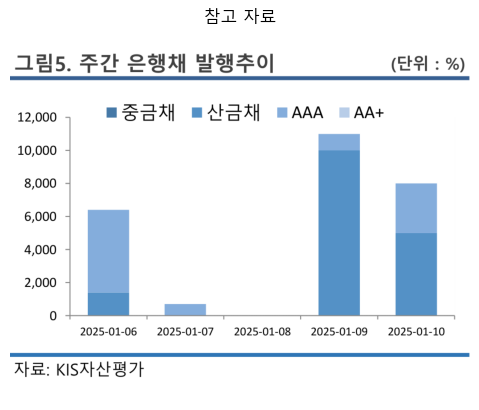

'2주 전인 2025년 1월 10일의 은행채 발행액을 말씀드리겠습니다. \n\n그 당시 은행채 발행액은 **2조 6,100억 원**이었으며, 이는 전주 대비 9,700억 원 증가한 수치입니다. 또한, 해당 시기 은행채 발행량 증가는 연내물 할인채 위주의 강세가 지속된 것으로 분석됩니다.\n\n국책은행 중 한국수출입은행의 연내물 할인채는 언더 10.3bp로 발행되었으며, 시중은행 중에선 우리은행의 연내물 할인채가 언더 15.9bp로 발행되었습니다. 이외에도 이표채 중 연내물의 강세가 계속되었는데, 국민은행의 1년 만기 이표채와 농협은행의 1년 만기 이표채 모두 언더로 발행되어 강세를 보였습니다. '

In [7]:
ask('2주 전 은행채 발행액은?')

In [8]:
ask('2025년 1월 24일과 2025년 1월 17일의 국공채 시장 동향을 비교하시오.')

제공된 문서들에 따르면, 2025년 1월 24일과 2025년 1월 17일 사이의 국공채 시장 동향은 다음과 같이 정리할 수 있습니다.

### 1. 전반적인 시장 동향
- **강세 흐름 유지**: 두 시점 모두 국내 채권시장에서 국고채를 비롯한 여러 채권이 강세를 보였습니다. 특히 국고채 30년물 입찰 성공과 낮은 소비자물가 상승률이 긍정적 영향을 미쳤습니다.
- **금리 인하 기대**: 미국과 한국 모두 금리 인하 기대감이 시장에 긍정적인 영향을 미치며, 국고채 금리는 전반적으로 하락하는 추세를 보였습니다.

### 2. 금융 시장 지표 변동
- **국고채 금리 하락**: 두 시기 동안 국고채 금리는 전반적으로 하락세를 보였으며, 이는 금리 인하 기대감과 관련이 깊습니다.
- **주식 시장 상승**: 주식 시장은 상승세를 나타냈고, 원/달러 환율은 상승하여 원화가 약세를 보였습니다.

### 3. 회사채 및 국고채 시장
- **크레딧 스프레드 축소**: 크레딧 스프레드는 감소했고, 수급 부담 완화로 인해 이러한 현상이 나타났습니다. 최상위 등급 회사채의 강세는 계속 이어질 것으로 보입니다.
- **금리 인하 기대 반영**: 금리 인하 기대가 반영되어 국고채 금리가 하락했으며, 회사채 시장에서도 안정적인 흐름이 관찰되었습니다.

### 4. CD 및 CP 시장
- **금리 하락과 발행 증가**: CD와 CP 금리는 모두 하락세를 보였고, 발행액도 증가하면서 시장이 전반적으로 강세를 유지했습니다.

### 종합 의견
두 시기의 국공채 시장은 금리 인하 기대와 정치적·경제적 요인들이 결합하여 전반적으로 강세를 유지하는 모습을 보였습니다. 특히 국고채와 회사채 시장에서 안정적이고 긍정적인 흐름이 지속되었으며, CD와 CP 시장 역시 강세를 이어갔습니다. 다만, 외환시장에서는 원화의 약세가 관찰되었지만, 전반적인 금융 시장은 긍정적인 방향으로 움직이고 있는 것으로 판단됩니다.


'제공된 문서들에 따르면, 2025년 1월 24일과 2025년 1월 17일 사이의 국공채 시장 동향은 다음과 같이 정리할 수 있습니다.\n\n### 1. 전반적인 시장 동향\n- **강세 흐름 유지**: 두 시점 모두 국내 채권시장에서 국고채를 비롯한 여러 채권이 강세를 보였습니다. 특히 국고채 30년물 입찰 성공과 낮은 소비자물가 상승률이 긍정적 영향을 미쳤습니다.\n- **금리 인하 기대**: 미국과 한국 모두 금리 인하 기대감이 시장에 긍정적인 영향을 미치며, 국고채 금리는 전반적으로 하락하는 추세를 보였습니다.\n\n### 2. 금융 시장 지표 변동\n- **국고채 금리 하락**: 두 시기 동안 국고채 금리는 전반적으로 하락세를 보였으며, 이는 금리 인하 기대감과 관련이 깊습니다.\n- **주식 시장 상승**: 주식 시장은 상승세를 나타냈고, 원/달러 환율은 상승하여 원화가 약세를 보였습니다.\n\n### 3. 회사채 및 국고채 시장\n- **크레딧 스프레드 축소**: 크레딧 스프레드는 감소했고, 수급 부담 완화로 인해 이러한 현상이 나타났습니다. 최상위 등급 회사채의 강세는 계속 이어질 것으로 보입니다.\n- **금리 인하 기대 반영**: 금리 인하 기대가 반영되어 국고채 금리가 하락했으며, 회사채 시장에서도 안정적인 흐름이 관찰되었습니다.\n\n### 4. CD 및 CP 시장\n- **금리 하락과 발행 증가**: CD와 CP 금리는 모두 하락세를 보였고, 발행액도 증가하면서 시장이 전반적으로 강세를 유지했습니다.\n\n### 종합 의견\n두 시기의 국공채 시장은 금리 인하 기대와 정치적·경제적 요인들이 결합하여 전반적으로 강세를 유지하는 모습을 보였습니다. 특히 국고채와 회사채 시장에서 안정적이고 긍정적인 흐름이 지속되었으며, CD와 CP 시장 역시 강세를 이어갔습니다. 다만, 외환시장에서는 원화의 약세가 관찰되었지만, 전반적인 금융 시장은 긍정적인 방향으로 움직이고 있는 것으로 판단됩니다.'

In [9]:
ask('지난달 은행채 발행액 총액은?')

핵심 내용 요약:
지난달(2024년 12월) 은행채 발행액 총액은 **4조 5,800억 원**으로 확인됩니다.

세부 분석 및 설명:
본문에 제시된 텍스트 정보에 따르면, 2024년 12월의 은행채 발행액 총액이 명확하게 명시되어 있으며, 이는 전월 대비 9,200억 원 증가한 금액입니다. 따라서 별도의 테이블 데이터 참조 없이도 정확한 답변을 제공할 수 있습니다.

결론 및 시사점:
이와 같은 증가 추세는 최근 시장 상황과 금리 변동 등 다양한 요인에 의해 영향을 받았을 가능성이 큽니다. 투자자들은 이러한 변화를 주시하며 향후 금융 시장의 동향을 예측하는 데 참고할 필요가 있습니다. 또한, 은행채 발행 증가는 자금 조달 수요를 반영하므로 관련 정책 결정자들도 이를 고려한 대응 전략을 마련해야 합니다.


'핵심 내용 요약:\n지난달(2024년 12월) 은행채 발행액 총액은 **4조 5,800억 원**으로 확인됩니다.\n\n세부 분석 및 설명:\n본문에 제시된 텍스트 정보에 따르면, 2024년 12월의 은행채 발행액 총액이 명확하게 명시되어 있으며, 이는 전월 대비 9,200억 원 증가한 금액입니다. 따라서 별도의 테이블 데이터 참조 없이도 정확한 답변을 제공할 수 있습니다.\n\n결론 및 시사점:\n이와 같은 증가 추세는 최근 시장 상황과 금리 변동 등 다양한 요인에 의해 영향을 받았을 가능성이 큽니다. 투자자들은 이러한 변화를 주시하며 향후 금융 시장의 동향을 예측하는 데 참고할 필요가 있습니다. 또한, 은행채 발행 증가는 자금 조달 수요를 반영하므로 관련 정책 결정자들도 이를 고려한 대응 전략을 마련해야 합니다.'

In [ ]:
ask('1101호 요약해줘')

**핵심 내용 요약**

현재 제공된 문서들과 테이블 데이터를 기반으로 '1101호'에 대한 직접적인 정보는 존재하지 않습니다. 대신, 여러 문서들을 통해 얻은 채권 시장의 전반적인 동향을 바탕으로 아래와 같은 주요 사항들을 확인할 수 있습니다.

1. **중장기물 중심 시장 동향**: 중장기물의 강세와 약세가 반복적으로 나타나며, 이는 시장의 중요한 특징으로 작용합니다.
2. **단기물과 장기물의 상반된 움직임**: 단기물은 대체로 약세를 보이며, 반면 장기물은 상대적으로 강세를 유지하고 있습니다.
3. **등급별 채권 변동성**: 특정 신용등급(A+, AA-)에 따른 시장 반응 차이가 두드러지며, 이는 투자자들의 관심을 끌고 있습니다.
4. **활발한 발행시장과 유통시장**: ABS 등 다양한 증권의 발행과 유통이 활발하게 이루어지고 있는 상황입니다.

**세부 분석 및 설명**

채권 시장에서 중장기물의 강세와 약세는 경제 전망과 금리 변동에 민감하게 반응하는 요소로, 시장의 방향성을 이해하는 데 중요한 지표가 됩니다. 또한, 단기물과 장기물의 서로 다른 움직임은 투자자들이 위험을 관리하기 위해 포트폴리오를 조정하는 방식을 반영하며, 특히 경기 불확실성이 클 때 이런 현상이 두드러집니다. 

신용등급별로 채권의 변동성이 다르게 나타난다는 점은 투자자들이 보다 세분화된 전략을 필요로 한다는 것을 의미합니다. 마지막으로, 발행시장과 유통시장이 활발하다는 것은 자본 조달과 투자가 여전히 활발하게 진행되고 있다는 긍정적인 신호로 해석될 수 있습니다.

**결론 및 시사점**

'1101호'에 대한 구체적인 정보는 없지만, 채권 시장의 전반적인 동향을 통해 몇 가지 중요한 통찰을 얻을 수 있습니다. 중장기물의 변화, 등급별 변동성, 그리고 시장의 활발한 활동 등은 향후 투자 전략 수립에 유용한 참고자료가 될 것입니다. 다만, '1101호'와 관련된 구체적인 정보를 원하신다면 추가 자료를 제공해 주시면 더욱 정확한 분석을 드릴 수 있을 것입니다. 앞으로도 지속적으로

"**핵심 내용 요약**\n\n현재 제공된 문서들과 테이블 데이터를 기반으로 '1101호'에 대한 직접적인 정보는 존재하지 않습니다. 대신, 여러 문서들을 통해 얻은 채권 시장의 전반적인 동향을 바탕으로 아래와 같은 주요 사항들을 확인할 수 있습니다.\n\n1. **중장기물 중심 시장 동향**: 중장기물의 강세와 약세가 반복적으로 나타나며, 이는 시장의 중요한 특징으로 작용합니다.\n2. **단기물과 장기물의 상반된 움직임**: 단기물은 대체로 약세를 보이며, 반면 장기물은 상대적으로 강세를 유지하고 있습니다.\n3. **등급별 채권 변동성**: 특정 신용등급(A+, AA-)에 따른 시장 반응 차이가 두드러지며, 이는 투자자들의 관심을 끌고 있습니다.\n4. **활발한 발행시장과 유통시장**: ABS 등 다양한 증권의 발행과 유통이 활발하게 이루어지고 있는 상황입니다.\n\n**세부 분석 및 설명**\n\n채권 시장에서 중장기물의 강세와 약세는 경제 전망과 금리 변동에 민감하게 반응하는 요소로, 시장의 방향성을 이해하는 데 중요한 지표가 됩니다. 또한, 단기물과 장기물의 서로 다른 움직임은 투자자들이 위험을 관리하기 위해 포트폴리오를 조정하는 방식을 반영하며, 특히 경기 불확실성이 클 때 이런 현상이 두드러집니다. \n\n신용등급별로 채권의 변동성이 다르게 나타난다는 점은 투자자들이 보다 세분화된 전략을 필요로 한다는 것을 의미합니다. 마지막으로, 발행시장과 유통시장이 활발하다는 것은 자본 조달과 투자가 여전히 활발하게 진행되고 있다는 긍정적인 신호로 해석될 수 있습니다.\n\n**결론 및 시사점**\n\n'1101호'에 대한 구체적인 정보는 없지만, 채권 시장의 전반적인 동향을 통해 몇 가지 중요한 통찰을 얻을 수 있습니다. 중장기물의 변화, 등급별 변동성, 그리고 시장의 활발한 활동 등은 향후 투자 전략 수립에 유용한 참고자료가 될 것입니다. 다만, '1101호'와 관련된 구체적인 정보를 원하신다면 추가 자료를 제공해 주시면 더욱 정확한 분석을 드릴 수 있

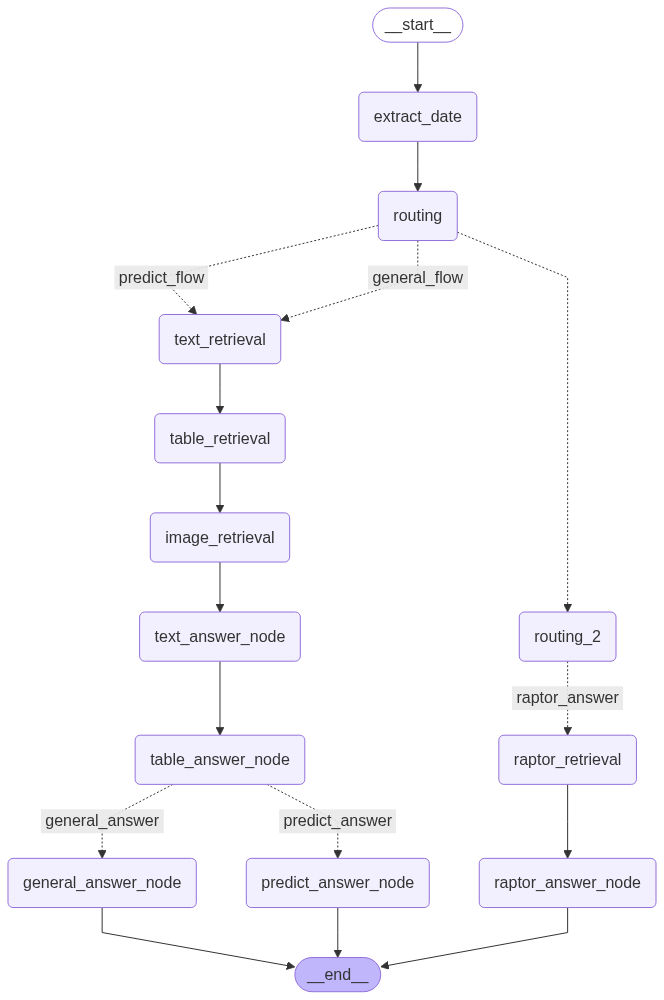

In [14]:
create_langgraph_agent()

In [17]:
ask('1101호 요약해줘')

일반
**핵심 내용 요약**

현재 제공된 문서들과 테이블 데이터를 기반으로 '1101호'에 대한 직접적인 정보는 존재하지 않습니다. 대신, 여러 문서들을 통해 얻은 채권 시장의 전반적인 동향을 바탕으로 아래와 같은 주요 사항들을 확인할 수 있습니다.

1. **중장기물 중심 시장 동향**: 중장기물의 강세와 약세가 반복적으로 나타나며, 이는 시장의 중요한 특징으로 작용합니다.
2. **단기물과 장기물의 상반된 움직임**: 단기물은 대체로 약세를 보이며, 반면 장기물은 상대적으로 강세를 유지하고 있습니다.
3. **등급별 채권 변동성**: 특정 신용등급(A+, AA-)에 따른 시장 반응 차이가 두드러지며, 이는 투자자들의 관심을 끌고 있습니다.
4. **활발한 발행시장과 유통시장**: ABS 등 다양한 증권의 발행과 유통이 활발하게 이루어지고 있는 상황입니다.

**세부 분석 및 설명**

채권 시장에서 중장기물의 강세와 약세는 경제 전망과 금리 변동에 민감하게 반응하는 요소로, 시장의 방향성을 이해하는 데 중요한 지표가 됩니다. 또한, 단기물과 장기물의 서로 다른 움직임은 투자자들이 위험을 관리하기 위해 포트폴리오를 조정하는 방식을 반영하며, 특히 경기 불확실성이 클 때 이런 현상이 두드러집니다. 

신용등급별로 채권의 변동성이 다르게 나타난다는 점은 투자자들이 보다 세분화된 전략을 필요로 한다는 것을 의미합니다. 마지막으로, 발행시장과 유통시장이 활발하다는 것은 자본 조달과 투자가 여전히 활발하게 진행되고 있다는 긍정적인 신호로 해석될 수 있습니다.

**결론 및 시사점**

'1101호'에 대한 구체적인 정보는 없지만, 채권 시장의 전반적인 동향을 통해 몇 가지 중요한 통찰을 얻을 수 있습니다. 중장기물의 변화, 등급별 변동성, 그리고 시장의 활발한 활동 등은 향후 투자 전략 수립에 유용한 참고자료가 될 것입니다. 다만, '1101호'와 관련된 구체적인 정보를 원하신다면 추가 자료를 제공해 주시면 더욱 정확한 분석을 드릴 수 있을 것입니다. 앞으로도 지속

"**핵심 내용 요약**\n\n현재 제공된 문서들과 테이블 데이터를 기반으로 '1101호'에 대한 직접적인 정보는 존재하지 않습니다. 대신, 여러 문서들을 통해 얻은 채권 시장의 전반적인 동향을 바탕으로 아래와 같은 주요 사항들을 확인할 수 있습니다.\n\n1. **중장기물 중심 시장 동향**: 중장기물의 강세와 약세가 반복적으로 나타나며, 이는 시장의 중요한 특징으로 작용합니다.\n2. **단기물과 장기물의 상반된 움직임**: 단기물은 대체로 약세를 보이며, 반면 장기물은 상대적으로 강세를 유지하고 있습니다.\n3. **등급별 채권 변동성**: 특정 신용등급(A+, AA-)에 따른 시장 반응 차이가 두드러지며, 이는 투자자들의 관심을 끌고 있습니다.\n4. **활발한 발행시장과 유통시장**: ABS 등 다양한 증권의 발행과 유통이 활발하게 이루어지고 있는 상황입니다.\n\n**세부 분석 및 설명**\n\n채권 시장에서 중장기물의 강세와 약세는 경제 전망과 금리 변동에 민감하게 반응하는 요소로, 시장의 방향성을 이해하는 데 중요한 지표가 됩니다. 또한, 단기물과 장기물의 서로 다른 움직임은 투자자들이 위험을 관리하기 위해 포트폴리오를 조정하는 방식을 반영하며, 특히 경기 불확실성이 클 때 이런 현상이 두드러집니다. \n\n신용등급별로 채권의 변동성이 다르게 나타난다는 점은 투자자들이 보다 세분화된 전략을 필요로 한다는 것을 의미합니다. 마지막으로, 발행시장과 유통시장이 활발하다는 것은 자본 조달과 투자가 여전히 활발하게 진행되고 있다는 긍정적인 신호로 해석될 수 있습니다.\n\n**결론 및 시사점**\n\n'1101호'에 대한 구체적인 정보는 없지만, 채권 시장의 전반적인 동향을 통해 몇 가지 중요한 통찰을 얻을 수 있습니다. 중장기물의 변화, 등급별 변동성, 그리고 시장의 활발한 활동 등은 향후 투자 전략 수립에 유용한 참고자료가 될 것입니다. 다만, '1101호'와 관련된 구체적인 정보를 원하신다면 추가 자료를 제공해 주시면 더욱 정확한 분석을 드릴 수 있

In [3]:
question = '2025년 1월 24일과 2025년 1월 17일의 국공채 시장 동향을 비교하시오.'
ask_langgraph(question)

'제공된 문서들에 따르면, 2025년 1월 24일과 2025년 1월 17일 사이의 국공채 시장 동향은 다음과 같이 정리할 수 있습니다.\n\n### 1. 전반적인 시장 동향\n- **강세 흐름 유지**: 두 시점 모두 국내 채권시장에서 국고채를 비롯한 여러 채권이 강세를 보였습니다. 특히 국고채 30년물 입찰 성공과 낮은 소비자물가 상승률이 긍정적 영향을 미쳤습니다.\n- **금리 인하 기대**: 미국과 한국 모두 금리 인하 기대감이 시장에 긍정적인 영향을 미치며, 국고채 금리는 전반적으로 하락하는 추세를 보였습니다.\n\n### 2. 금융 시장 지표 변동\n- **국고채 금리 하락**: 두 시기 동안 국고채 금리는 전반적으로 하락세를 보였으며, 이는 금리 인하 기대감과 관련이 깊습니다.\n- **주식 시장 상승**: 주식 시장은 상승세를 나타냈고, 원/달러 환율은 상승하여 원화가 약세를 보였습니다.\n\n### 3. 회사채 및 국고채 시장\n- **크레딧 스프레드 축소**: 크레딧 스프레드는 감소했고, 수급 부담 완화로 인해 이러한 현상이 나타났습니다. 최상위 등급 회사채의 강세는 계속 이어질 것으로 보입니다.\n- **금리 인하 기대 반영**: 금리 인하 기대가 반영되어 국고채 금리가 하락했으며, 회사채 시장에서도 안정적인 흐름이 관찰되었습니다.\n\n### 4. CD 및 CP 시장\n- **금리 하락과 발행 증가**: CD와 CP 금리는 모두 하락세를 보였고, 발행액도 증가하면서 시장이 전반적으로 강세를 유지했습니다.\n\n### 종합 의견\n두 시기의 국공채 시장은 금리 인하 기대와 정치적·경제적 요인들이 결합하여 전반적으로 강세를 유지하는 모습을 보였습니다. 특히 국고채와 회사채 시장에서 안정적이고 긍정적인 흐름이 지속되었으며, CD와 CP 시장 역시 강세를 이어갔습니다. 다만, 외환시장에서는 원화의 약세가 관찰되었지만, 전반적인 금융 시장은 긍정적인 방향으로 움직이고 있는 것으로 판단됩니다.'

In [4]:
question = '지난 달 은행채 발행액 총액은?'
ask_langgraph(question)

'**핵심 내용 요약**: 현재 제공된 텍스트 정보만으로는 2024년 12월의 은행채 발행액 총액을 정확히 파악하기 어려우나, 테이블 정보를 활용하면 약 22,000백만원의 발행액을 확인할 수 있습니다.\n\n**세부 분석 및 설명**:\n- 주어진 텍스트에서는 최신 몇 주간의 은행채 발행액 변화는 나타나지만, 구체적으로 2024년 12월의 전체 발행액에 대한 직접적인 데이터가 없습니다.\n- 반면, 테이블에는 각 날짜별 발행액이 기록되어 있으며 이를 모두 합산한 결과, 대략 22,000백만원이란 값을 도출할 수 있습니다.\n- 이 값은 여러 요인에 의해 변동될 가능성이 있지만, 현재로서는 가장 근접한 추정치가 될 것입니다.\n\n**결론 및 시사점**: 비록 직접적 데이터는 부족하나, 테이블 정보를 기반으로 한 계산 결과는 2024년 12월 은행채 발행액이 약 22,000백만원임을 시사합니다. 다만, 실제 총액은 시장 상황이나 기타 변수들에 따라 달라질 수 있으므로 주의 깊게 모니터링해야 합니다.'

In [5]:
question = '1101호 요약해줘'
ask_langgraph(question)

"**핵심 내용 요약**\n\n현재 제공된 문서들과 테이블 데이터를 기반으로 '1101호'에 대한 직접적인 정보는 존재하지 않습니다. 대신, 채권 시장의 전반적인 동향을 통해 관련 정보를 유추할 수 있습니다.\n\n**세부 분석 및 설명**\n\n1. **중장기물 중심 시장 동향**: 여러 문서에서 중장기물의 강세와 약세가 반복적으로 나타나며, 이는 시장의 주요 트렌드로 보입니다.\n2. **단기물과 장기물의 상반된 움직임**: 단기물은 대체로 약세를 보이지만, 장기물은 상대적으로 강세를 유지하고 있는 모습입니다.\n3. **특정 등급 채권의 변동성**: 특정 등급(A+, AA-)에 따른 시장 반응 차이가 두드러지며, 이러한 차별화가 주목받고 있습니다.\n4. **발행시장과 유통시장의 활발한 움직임**: ABS 등 다양한 증권의 발행 및 유통이 활발하게 이루어지고 있습니다.\n\n이러한 분석을 통해 '1101호'에 대한 직접적인 정보는 없지만, 채권 시장의 전반적인 흐름은 파악할 수 있습니다.\n\n**결론 및 시사점**\n\n'1101호'에 대한 구체적인 정보는 제공되지 않았으나, 채권 시장의 중장기적 동향과 등급별 변동성을 이해하는 것이 중요합니다. 향후 보다 구체적인 자료를 확보하면 더욱 정교한 분석이 가능할 것입니다. 추가적인 정보 제공을 통해 도움을 드릴 수 있으니, 필요시 문의 바랍니다."

In [6]:
question = '다음달 회사채 시장과 스프레드 전망 알려줘'
ask_langgraph(question)

'**핵심 내용 요약**\n\n다음 달 회사채 시장과 스프레드 전망을 살펴보면, 최근 몇 달간의 스프레드 증가 추세가 지속될 가능성이 큽니다. 특히 AAA 등급의 지속적인 상승과 A등급에서의 큰 폭의 변화가 관찰되었으며, 유통시장은 혼조세지만 발행시장은 활발하고 우량등급 회사채 수요가 높아 스프레드 축소가 예상됩니다. 또한, 정치적 불확실성과 글로벌 경제 상황이 주요 변수로 작용할 것입니다.\n\n**세부 분석 및 설명**\n\n최근 몇 달간 회사채 스프레드는 전반적으로 증가하는 경향을 보였으며, 특히 AAA 등급의 스프레드가 전월 대비 5.9bp 증가한 53.3bp, A등급은 5.7bp 증가한 168.7bp를 기록하였습니다. 이러한 추세는 연말연시 관망세로 인한 제한적 변동폭 속에서도 계속되었고, 외부 요인들로 인해 추가적인 영향이 있을 가능성이 제기됩니다. \n\n또한, 유통시장은 뚜렷한 방향성을 보이지 않고 있으나 발행시장은 활발하며, 우량등급 회사채에 대한 높은 수요가 스프레드 축소를 이끌고 있습니다. 이와 더불어, 충분한 크레디트 수요가 유입됨에 따라 스프레드가 지지받을 것으로 예상되며, A등급 이하 비우량 등급에서는 스프레드 축소 경향이 더욱 두드러질 전망입니다.\n\n테이블 데이터를 통해 본 결과, 연말효과로 인해 발행시장이 다소 위축될 수 있지만 크레딧 스프레드는 확대되는 추세이며, 단기 및 중기 구간의 금리 상승으로 수익률 곡선이 가팔라지고 있습니다. 다수의 기업이 회사채 발행 계획을 가지고 있으며, 발행 스프레드는 개별 민평 대비 ±30bp 범위로 형성될 것으로 보입니다. 전반적으로 시장 분위기는 약하나 크레딧 스프레드 확대로 투자자 관심이 증가하고 있고, Fed의 금리 정책 변화가 국내 채권 시장에 영향을 미치며 회사채 금리 하락 경향을 보이고 있습니다.\n\n**결론 및 시사점**\n\n다음 달 회사채 시장은 현재의 스프레드 증가 추세를 이어갈 가능성이 높으나, 정치적 불확실성과 글로벌 경제 상황에 따른 변동성에 유의해야 합니다. 발행시장